In [17]:
import pickle
from datetime import datetime
from copy import deepcopy
from pathlib import Path
from random import choices, seed
from ase.visualize import view
# Only import reload if one of the custom libraries is modified while the notebook is running, otherwise it messes up pickle
# from importlib import reload
import numpy as np
from ase import Atoms
from itertools import cycle, islice
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r"\usepackage{libertine}"
%matplotlib widget
import matplotlib.pyplot as plt
import graphical
# reload(graphical)
import abtem_backend as backend
#reload(backend)
import ase_funcs
#reload(ase_funcs)
import SingleOrigin as so
#reload(so)

In [ ]:
# Preview the cif file to make sure it looks right
# This pops up a new interactive window where you can rotate / pan / zoom / etc. with the cif model
cif_cell = graphical.gui_open(ffmt="cif")
view(cif_cell)
# Technically, reading the cif returns a generator (because cifs can store multiple crystal structures in one file),
# in which case this only shows the first valid structure.  But practically, just avoid using cif files with multiple structures in them

First we want to check some thin samples; with these, we can exhaustively enumerate the possible configurational variations within a column, which should give us a little bit of insight into how quickly we're losing information about the in-column chemistry.  Let's build models up to 4 projected cells thick.

In [ ]:
thin_models = backend.build_from_cif(graphical.gui_get_path(),
                                     zas=(1, 1, 0),
                                     tks=[2, 6, 8, 12],
                                     tilings=(2, 2))

In [ ]:
# Preview a model to make sure it looks right
view(thin_models[-1].atoms)

In [ ]:
chopped_models = [ase_funcs.split_by_projected_columns(model.atoms, kinds="Al") for model in thin_models]

In [ ]:
# Treat the one cell thick case specially, since we just want to pick at (pseudo)random
seed(12)  # This seed gives an actual 50:50 ratio
syms = choices(["Al", "Sc"], weights=[0.5, 0.5], k=len(chopped_models[0]))
seed(None)  # Unset the seed, so we don't mess up later steps
for i, col in enumerate(chopped_models[0]):
    col[0].symbol = syms[i]

In [ ]:
# Then, for the rest, let's exhaustively go through all possible variations and assign them to a column
# For the four cell thick case, this is 1:1; for thinner models, we will need to repeat some
for model, cm in zip(thin_models[1:], chopped_models[1:]):
    n_vars = pow(2, len(cm[0]))
    # Get variations, and unwrap the returned tuples to remove the labels (which we don't need right now)
    new_cols = [col[1] for col in ase_funcs.gen_variations(Atoms(cm[0]), subs=("Al", "Sc"))]

    if len(cm) >= n_vars:
        new_cols = list(islice(cycle(new_cols), len(cm)))  # Repeat to account for all columns
    elif len(cm) <= n_vars:
        raise ValueError("Too many possible variations; increase supercell x-y size")
    # else len(cm) == n_vars, and we don't need to change new_cols

    # ndarray for fast & easy 2D lookup
    # Index guide: [column, pos_in_col, tuple], where for tuple 0 is index in model and 1 is symbol
    cm_array = np.array([[(atom.index, atom.symbol) for atom in col] for col in cm])
    for i, col in enumerate(new_cols):
        for j, atom in enumerate(col):
            cm_array[i, j, 1] = atom.symbol
    del new_cols  # We don't need this anymore
    #  Finally, we can modify the models to have the correct elements!
    for atom in model.atoms:
        if atom.symbol in ["Al"]:
            cm_location = np.where(cm_array[:, :, 0] == str(atom.index))
            atom.symbol = cm_array[cm_location[0], cm_location[1], 1][0]


In [2]:
# STEM simulation setup
db = backend.DetectorBuilder()
potential_parameters = backend.PotentialParameters(sampling=0.1,
                                                   slice_thickness=1,
                                                   device="gpu",
                                                   storage="cpu",
                                                   fp_cfgs=100,
                                                   fp_sigmas={"Al": 0.0567,  # DOI: 10.1107/S0108767309004966
                                                              "Sc": 0.0567,  # No good source for this, assuming the same as Al
                                                              "N":  0.0593})
# Lower convergence angle helps a little bit with chemistry, but of course there's a tradeoff with resolution
# I know I can get atomic res with 17.9, and going down to 10 only helps a small amount with chemical quantification
probe_parameters = backend.ProbeParameters(device="gpu", convergence=17.9)

In [ ]:
# STEM simulation; it's fast for models this small!  Only takes about 2 minutes
thin_results = []
for model in thin_models:
    thin_results.append(backend.sim_stem([model],
                                    db,
                                    potential_prms=potential_parameters,
                                    probe_prms=probe_parameters,
                                    kinds=["haadf"]))

In [ ]:
# Process the results into HAADF images
imgs = []
for result in thin_results:
    res = result[0]  # Unwrap single element list
    meas = res.measurement[0]
    img = meas.interpolate(tuple([x/4 for x in res.grid.sampling]), kind="fft").tile((3, 3)).array
    img = so.image_norm(img)
    imgs.append(img)

In [ ]:
# Preview one of the images, to make sure
plt.clf()
plt.imshow(imgs[3], cmap="binary")
plt.axis("off")
plt.show()

Now that we have simulated HAADF images, we'll fit with SingleOrigin as this allows us to get the integrated column intensity as a measure of chemistry at a per-column level.  There are a couple of notes here to make sure this works right:
1. When selecting FFT spots, first select the $0 0 \bar{2}$ spot (right of the origin), and then select the $1 \bar{1} 0$ spot (above the origin).  This ensures proper orientation of the unit cell with respect to the image.
2. When selecting a column as the origin of the fitted lattice, use the column just to the right of the centerline and 6 projected cells up from the bottom of the image.  This both ensures correct alignment of the unit cell with respect to the image, and ensure that some later analysis steps with hard-coded "magic numbers" work out correctly.  If done correctly, the peak should be found at image coordinates `[196, 196]`.

In [ ]:
cif_path = r"C:\Users\charles\Documents\AlScN\raw\AlN.cif"
uc = so.UnitCell(cif_path)

za = [1, 1, 0]  # Zone axis direction
a2 = [0, 0, -1]  # Apparent horizontal axis in projection
a3 = [1, -1, 0]  # Most vertical axis in projection

uc.project_zone_axis(za, a2, a3, ignore_elements=["N"])
uc.combine_prox_cols()

In [ ]:
uc.plot_unit_cell()

In [ ]:
hrimgs = [so.HRImage(img) for img in imgs]
lattices = [hrimg.add_lattice("AlN", uc) for hrimg in hrimgs]
matplotlib.use("QtAgg")
for lattice in lattices:
    lattice.fft_get_basis_vect(a1_order=2, a2_order=1, sigma=2)
%matplotlib widget

In [ ]:
matplotlib.use("QtAgg")
for lattice in lattices:
    lattice.roi_mask = np.ones(imgs[0].shape)
    lattice.define_reference_lattice()
%matplotlib widget

In [ ]:
for lattice in lattices:
    lattice.fit_atom_columns(buffer=0, local_thresh_factor=0, use_background_param=False,
                             use_bounds=True, use_circ_gauss=False, parallelize=True,
                             peak_grouping_filter=None)

    # Must have only one column per projected unit cell.  If no sublattice meets this criterion,
    #  specify a specific column in the projected cell.
    lattice.refine_reference_lattice(filter_by='elem', sites_to_use='all')

In [ ]:
# Check one of the fits to make sure everything worked
hrimgs[1].plot_atom_column_positions(scatter_kwargs_dict={"s": 20}, scalebar_len_nm=None,
                                     outlier_disp_cutoff=100, fit_or_ref="ref")

Finally, we need to analyze the images.  Unfortunately, by far the simplest way to do this is to use some "magic numbers" that correspond to our understanding of the models used to generate the images.  The magic numbers here are:
1. `sc_counts`, which hold (for each model/image) the number of Sc atoms in a projected column.  This has been done for a single supercell (i.e. not the entire $3\times 3$ tiled image).  The indices in `sc_counts` are: image/model number, $u$ coordinate (ascending), and $v$ coordinate (ascending).  The order is, of course, crucial.
2. $u_0$ and $v_0$, which are picked such that - so long as the correct origin column was chosed during the SingleOrigin fitting step - the $u$ and $v$ coordinates of one supercell are properly registered against `sc_counts`.
3. The increment lists for $u$ and $v$, which span a full supercell.  $v$ needs to be offset by $1/3$ when $u$ is an integer to properly find all columns in the supercell, which might also be considered a magic number.

In [ ]:
# These will always have the same columns, but not necessarily in the same order
# Thus, these will need to be updated whenever the models are regenerated
# View the models with this line of code, and make sure to rotate -90 degrees about the Z axis
# Then, begin from the bottom left and count upward (-X direction) first, then right (+Y direction); record the Sc counts per column
view(thin_models[3].atoms)

In [ ]:
sc_counts = [None, None, None, None]
sc_counts[0] = [[1, 0, 1, 0],
                [1, 1, 0, 0],
                [1, 0, 1, 1],
                [0, 0, 0, 1]]
sc_counts[1] = [[2, 1, 1, 1],
                [2, 1, 1, 0],
                [0, 0, 1, 1],
                [1, 2, 0, 2]]
sc_counts[2] = [[3, 2, 1, 2],
                [3, 1, 2, 2],
                [0, 2, 1, 1],
                [2, 1, 0, 1]]
sc_counts[3] = [[4, 3, 2, 2],
                [2, 2, 3, 1],
                [2, 3, 1, 1],
                [2, 1, 0, 3]]

In [ ]:
# For more convenient analysis
frames = []
for lat in lattices:
    frame = deepcopy(lat.at_cols)
    frame.drop(["site_frac", "x", "y", "weight"], axis=1, inplace=True)  # We don't need these cols
    frame.reset_index(drop=True, inplace=True)
    frames.append(frame)

In [ ]:
u0, v0 = -1.5, -2/3  # This depends on selecting the correct column in the interactive step: peak coordinates [196, 196]
us = [u0 + increment for increment in [0, 0.5, 1, 1.5]]
vs = [v0 + increment for increment in [0, 1, 2, 3]]

col_ints = []
for frame in frames:
    frame_ints = []
    for u in us:
        _ints = []
        for v in vs:
            if int(u) == u:
                # On half-integer u steps we need to bump v up by 1/3
                v = v + 1/3
            match = frame.loc[(np.isclose(frame["u"], u, atol=0.001)) & (np.isclose(frame["v"], v, atol=0.001))]
            _ints.append(float(match.total_col_int))
        frame_ints.append(_ints)
    col_ints.append(frame_ints)


In [ ]:
%matplotlib widget
which = 3  # Which thickness to plot for
clist = [count for sublist in sc_counts[which] for count in sublist]
ilist = [intensity for sublist in col_ints[which] for intensity in sublist]
plt.scatter(clist, ilist, None, "purple", "x", label="Data from Simulation")

fit = np.polyfit(clist, ilist, deg=1, full=True)
linfit_xs = np.linspace(min(clist), max(clist))
linfit_ys = linfit_xs*fit[0][0] + fit[0][1]
plt.plot(linfit_xs, linfit_ys, "g--", label=f"Linear Fit, $R^2 = ${round(1 - fit[1][0] / np.sum((ilist - np.mean(ilist))**2), 3)}")

plt.xlabel("Per-Column Scandium Count")
plt.ylabel("Integrated Column Intensity (a.u.)")
plt.xticks(np.arange(0, max(clist)+1, 1))
plt.legend()
plt.show()

In [4]:
# Measured R^2 values for several trials
# Each sublist here is a thickness, with repeats in the list representing trials
rsquareds = [[0.996, 0.997, 0.998, 0.998, 0.999],  # 1 u.c.
             [0.835, 0.852, 0.841, 0.851, 0.828],  # 2 u.c.
             [0.891, 0.916, 0.924, 0.924, 0.922],  # 3 u.c.
             [0.806, 0.765, 0.777, 0.781, 0.806]]  # 4 u.c.
rsqaureds = np.array(rsquareds).T  # Transpose so that it works with a simple call to boxplot

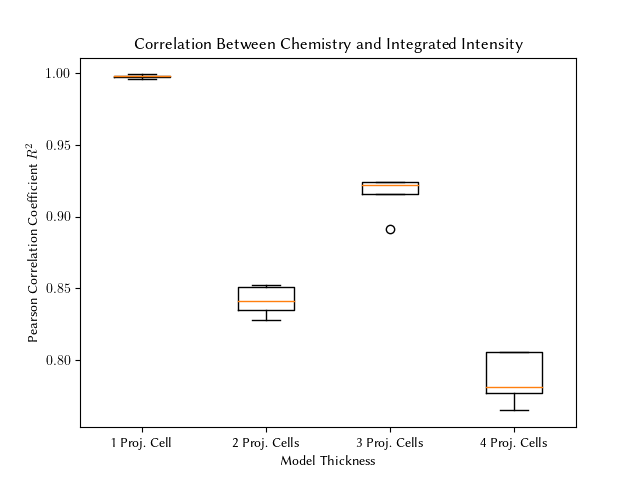

In [18]:
%matplotlib widget
labs = ["1 Proj. Cell", "2 Proj. Cells", "3 Proj. Cells", "4 Proj. Cells"]
fig, ax = plt.subplots()
ax.boxplot(rsquareds)
ax.set_xticklabels(labs)
ax.set_ylabel("Pearson Correlation Coefficient $R^2$")
ax.set_xlabel("Model Thickness")
plt.title("Correlation Between Chemistry and Integrated Intensity")
plt.show()

After having a look at this data, here are some tentative conclusions:
1. The single-layer spread (associated with frozen phonons and local neighborhood) is capping $R^2 \approx 0.998$ with a narrow spread -- not perfect of course, but quite good!
2. For thicker samples, ordering and probe spread effects start to come into play.  Lower convergence angles help with this, but of course at some point we will lose atomic resolution which defeats the purpose.  I know 17.9 will give resolved columns, so I'll stick with that.
3. I can't quite figure out why 3 projected cells has a better correlation than 2 projected cells; I think it may have to do with the increased distance between the integrated intensity for a column with no Sc and a column with 3 Sc (compared to the max of 2 Sc in the 2 projected cells case), in which case the reductin in correlation for the 4-cell thick case suggests that ordering effects will, in the long run, outpace the effect of this increased distance.

This is reasonable for now; at this point it's probably best to start working on thicker simulations to see where we end up with much thicker samples.  These will be more realistic for actual TEM samples, which aren't often less than 10nm thick.  I'll test a range from 10nm to 30nm thick, with Sc content from 10% to 30%, and each trial will get 32 trials.  Doing it this way means I can simulate 4 different columns in each image, leading to 8 trials per condition.  I'll also take special account of the endmembers (0% Sc and 100% Sc) to put bounds on where integrated intensity values can fall for each thickness, and get an idea of how much intensity spread there is due to non-chemistry effects.

In [2]:
# Random seeds from random.org (x108)
with open(graphical.gui_get_path()) as infile:
    seeds = [int(line.rstrip("\n")) for line in infile]

conditions = [{"t": 100, "c": 0.1}, {"t": 100, "c": 0.2}, {"t": 100, "c": 0.3},  # t => thickness, c => chemistry (Sc %)
              {"t": 200, "c": 0.1}, {"t": 200, "c": 0.2}, {"t": 200, "c": 0.3},
              {"t": 300, "c": 0.1}, {"t": 300, "c": 0.2}, {"t": 300, "c": 0.3},
              {"t": 100, "c": 0.0}, {"t": 200, "c": 0.0}, {"t": 300, "c": 0.0},  # Wurtzite AlN endmember
              {"t": 100, "c": 1.0}, {"t": 200, "c": 1.0}, {"t": 300, "c": 1.0}]  # Wurtzite ScN endmember

In [3]:
thick_models = backend.build_from_cif(graphical.gui_get_path(),
                                      zas=(1, 1, 0),
                                      tks=[conditions[i]["t"] for i in range(len(conditions))],
                                      tilings=(1, 1))

In [4]:
thick_models = [x for sublist in  # Repeat each model 3 times, and flatten
                [[deepcopy(model), deepcopy(model), deepcopy(model)] for model in thick_models]
                for x in sublist]  # Now the first 27 models are the t/c trials, and the last 18 are the endmember trials (no randomization)

# Warning: reusing this name, be careful of running this out of order
chopped_models = [ase_funcs.split_by_projected_columns(model.atoms, kinds="Al") for model in thick_models]

In [5]:
for model_idx, (cm, model) in enumerate(zip(chopped_models, thick_models)):
    new_cols = []
    for col_idx, col in enumerate(cm):
        seednum = 4*model_idx+col_idx
        if seednum <= 107:
            seed = seeds[seednum]
        else:
            seed = 0  # Doesn't matter, these aren't being randomized
        column = ase_funcs.randomize_chem(Atoms(col),
                                          replacements={"Al": {"Sc": conditions[int(np.floor(model_idx/3))]["c"]}},
                                          prseed=seed)
        new_cols.append(column)

    swap_list = []
    for new_col, old_col in zip(new_cols, cm):
        for new_atom, old_atom in zip(new_col, old_col):
            swap_list.append({"idx": old_atom.index, "sym": new_atom.symbol})
    del new_cols  # We don't need this anymore

    for atom in model.atoms:
        if atom.symbol in ["Al"]:
            new_symbol = next(entry["sym"] for entry in swap_list if entry["idx"] == atom.index)
            atom.symbol = new_symbol

# Actual in-column % might be slightly off, especially for thinner models, so record it
for model in thick_models:
    model.atoms *= (4, 4, 1)  # Tile to 4x4 to avoid prove self-interference
    syms = model.atoms.get_chemical_symbols()
    n_Al, n_Sc = syms.count("Al"), syms.count("Sc")
    actual_percent = n_Sc / (n_Al + n_Sc)
    model.name = f"{actual_percent:0.4f}"  # Store in name, which is otherwise unused here

view(thick_models[0].atoms)

<Popen: returncode: None args: ['C:\\Users\\charles\\.jupyter\\venv\\Scripts...>

Now we'll actually simulate the thick models.  We are running a total of 45 simulations, so even if they only take a few minutes each this will be slow.  Thus, this will need to be done in a loop, and measurements should be saved to a file after each simulation in case of a crash.  We will need to rebuild the potential parameters for each run, since we're running multiple trials with different seeds, and we want those seeds to affect the FrozenPhonons.

In [6]:
pickle_loc = graphical.gui_get_path(is_file=False)
pickle_name = f"simulation_{int(datetime.now().timestamp())}.pkl"
thick_results = []

db = backend.DetectorBuilder(annular_inner_angle=46, annular_outer_angle=200,
                             segmented_inner_angle=11, segmented_outer_angle=43)

probe_parameters = backend.ProbeParameters(device="gpu", convergence=17.9,
                                           defocus=20,
                                           stig=7, stig_rot=2.7,
                                           coma=335, coma_rot=2.7,
                                           spherical=-5200)

# For 45 simulations, this took just about exactly 1hr to run
for i, model in enumerate(thick_models):
    # Warning: reusing this name, be careful of running this out of order
    potential_parameters = backend.PotentialParameters(sampling=0.1,
                                                       slice_thickness=1,
                                                       device="gpu",
                                                       storage="cpu",
                                                       fp_cfgs=100,
                                                       fp_sigmas={"Al": 0.0567,  # DOI: 10.1107/S0108767309004966
                                                                  "Sc": 0.0554,  # No good source for this, assuming ~2.3% < Al
                                                                  "N":  0.0593},
                                                       seed=seeds[i])
    thick_results.append(backend.sim_stem([model],
                                          db,
                                          potential_prms=potential_parameters,
                                          probe_prms=probe_parameters,
                                          kinds=["haadf", "dpc"]))
    with open(pickle_loc / pickle_name, "w+b") as picklefile:
        pickle.dump(thick_results, picklefile)  # Dump the cumulative results to a file after each run, just in case

C:\Users\charles\.jupyter\venv\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [19]:
unpickle_file = graphical.gui_get_path(is_file=True)
with open(unpickle_file, "rb") as upf:
    thick_results = pickle.load(upf)

In [20]:
thk_imgs = []
for result in thick_results:
    res = result[0]  # Unwrap single element list
    meas = res.measurement[0]
    img = meas.interpolate(tuple([x/4 for x in res.grid.sampling]), kind="fft").tile((3, 3)).array  # Big so the FFT step works better
    img = so.image_norm(img)
    thk_imgs.append(img)

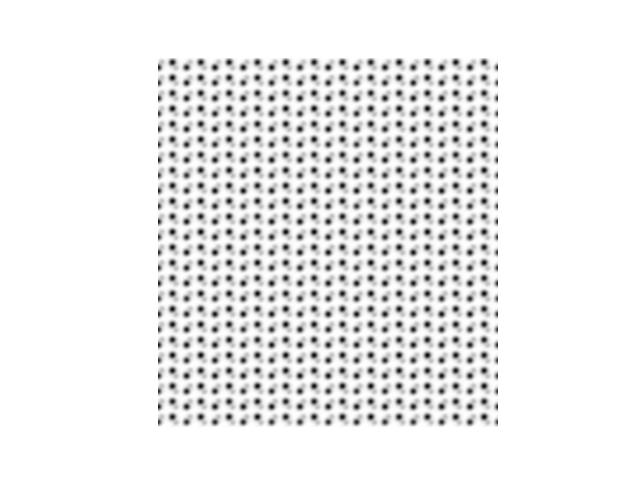

In [21]:
# Preview one of the images, if desired
plt.clf()
plt.imshow(thk_imgs[0], cmap="binary")
plt.axis("off")
plt.show()

In [22]:
# WARNING: Som of the SingleOrigin variable names (e.g. "uc") are going to be overwritten, so be careful!

cif_path = r"C:\Users\charles\Documents\AlScN\raw\AlN.cif"
uc = so.UnitCell(cif_path)

za = [1, 1, 0]  # Zone axis direction
a2 = [0, 0, -1]  # Apparent horizontal axis in projection
a3 = [1, -1, 0]  # Most vertical axis in projection

uc.project_zone_axis(za, a2, a3, ignore_elements=["N"])
uc.combine_prox_cols()

transformed lattice parameters: 
 a1:     3.111 
 a2:     4.978 
 a3:     5.3884 
 alpha:  90.0 
 beta:   90.0 
 gamma:  90.0 

Distances (in Angstroms) being combined...
None to combine


,u,v,elem,site_frac,x,y,weight
0,0.0,0.66666,Al,1.0,0.000,1.796119,1
1,0.5,0.33333,Al,1.0,2.489,0.898059,1


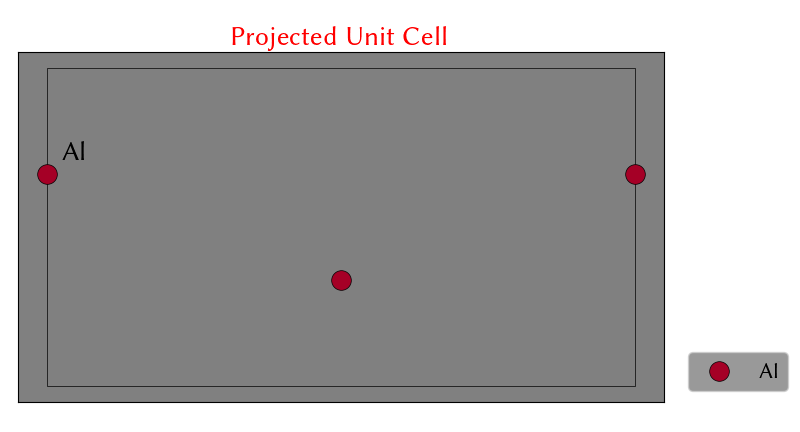

In [23]:
uc.plot_unit_cell()

In [24]:
thk_hrimgs = [so.HRImage(img) for img in thk_imgs]
thk_lattices = [hrimg.add_lattice("AlN", uc) for hrimg in thk_hrimgs]
matplotlib.use("QtAgg")
for lattice in thk_lattices:
    lattice.fft_get_basis_vect(a1_order=2, a2_order=1, sigma=1)
    lattice.roi_mask = np.ones(thk_imgs[0].shape)
    # We need to wait for the user before we try to continue, or else SingleOrigin trips over itself
    if not graphical.gui_wait_for_user():
        raise RuntimeError("Operation aborted by user")
%matplotlib widget

[[366. 342.]
 [342. 320.]]
done selecting 

[[366. 342.]
 [342. 320.]]
done selecting 

[[366. 342.]
 [342. 320.]]
done selecting 

[[366. 342.]
 [342. 320.]]
done selecting 

[[366. 342.]
 [342. 320.]]
done selecting 

[[366. 342.]
 [342. 320.]]
done selecting 

[[366. 342.]
 [342. 320.]]
done selecting 

[[366. 342.]
 [342. 320.]]
done selecting 

[[366. 342.]
 [342. 320.]]
done selecting 

[[366. 342.]
 [342. 320.]]
done selecting 

[[366. 342.]
 [342. 320.]]
done selecting 

[[366. 342.]
 [342. 320.]]
done selecting 

[[366. 342.]
 [342. 320.]]
done selecting 

[[366. 342.]
 [342. 320.]]
done selecting 

[[366. 342.]
 [342. 320.]]
done selecting 

[[366. 342.]
 [342. 320.]]
done selecting 

[[366. 342.]
 [342. 320.]]
done selecting 

[[366. 342.]
 [342. 320.]]
done selecting 

[[366. 342.]
 [342. 320.]]
done selecting 

[[366. 342.]
 [342. 320.]]
done selecting 

[[366. 342.]
 [342. 320.]]
done selecting 

[[366. 342.]
 [342. 320.]]
done selecting 

[[366. 342.]
 [342. 320.]]
done 

In [25]:
matplotlib.use("QtAgg")
for lattice in thk_lattices:
    lattice.define_reference_lattice()
%matplotlib widget

pick coordinates: [312.72 351.5 ] 

detected peak coordinates: [314, 351] 

Creating reference lattice...
Performing rough reference lattice refinement...
Refinement iteration 1
0 min 0.00 sec
Refinement iteration 2
0 min 0.02 sec
Refinement iteration 3
0 min 0.02 sec
pick coordinates: [312.72 351.5 ] 

detected peak coordinates: [314, 351] 

Creating reference lattice...
Performing rough reference lattice refinement...
Refinement iteration 1
0 min 0.00 sec
Refinement iteration 2
0 min 0.03 sec
Refinement iteration 3
0 min 0.02 sec
pick coordinates: [312.72 351.5 ] 

detected peak coordinates: [314, 351] 

Creating reference lattice...
Performing rough reference lattice refinement...
Refinement iteration 1
0 min 0.00 sec
Refinement iteration 2
0 min 0.02 sec
Refinement iteration 3
0 min 0.02 sec
pick coordinates: [312.72 351.5 ] 

detected peak coordinates: [314, 351] 

Creating reference lattice...
Performing rough reference lattice refinement...
Refinement iteration 1
0 min 0.00 sec


In [26]:
for lattice in thk_lattices:
    lattice.fit_atom_columns(buffer=0, local_thresh_factor=0, use_background_param=False,
                             use_bounds=True, use_circ_gauss=False, parallelize=True,
                             peak_grouping_filter=None)
    # Must have only one column per projected unit cell.  If no sublattice meets this criterion,
    #  specify a specific column in the projected cell.
    lattice.refine_reference_lattice(filter_by='elem', sites_to_use='all')

Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.56 sec
Step 3(grouping masks): 0 min 0.58 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:04<00:00, 138.42it/s]


Done. Fitting time: 0 min 4.3 sec
Origin shift: [-0.17899884  0.30954887]
Optimized basis vectors: [[ 5.70503555e+01 -3.57674910e-02]
 [-2.87144920e-04 -3.09983154e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.3916 %
Shear component: 0.000618 (radians)
Estimated Pixel Size: 8.709 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.57 sec
Step 3(grouping masks): 0 min 0.57 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2223.64it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [-0.20703965  0.30936429]
Optimized basis vectors: [[ 5.70492223e+01 -3.46554470e-02]
 [ 4.49534101e-04 -3.09995348e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.3975 %
Shear component: 0.000622 (radians)
Estimated Pixel Size: 8.708 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.57 sec
Step 3(grouping masks): 0 min 0.61 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 1309.09it/s]


Done. Fitting time: 0 min 0.6 sec
Origin shift: [-0.18360776  0.31972402]
Optimized basis vectors: [[ 5.70525922e+01 -3.56843149e-02]
 [ 6.49645884e-04 -3.09994015e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.3912 %
Shear component: 0.000646 (radians)
Estimated Pixel Size: 8.708 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.57 sec
Step 3(grouping masks): 0 min 0.57 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2215.37it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [-0.1972801   0.27963511]
Optimized basis vectors: [[ 5.70344442e+01 -1.99102302e-02]
 [ 1.86445702e-04 -3.09997816e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4241 %
Shear component: 0.000355 (radians)
Estimated Pixel Size: 8.710 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.57 sec
Step 3(grouping masks): 0 min 0.57 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2034.74it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [-0.20366761  0.3275648 ]
Optimized basis vectors: [[ 5.70375354e+01 -2.18347978e-02]
 [ 6.66907775e-04 -3.09994945e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4178 %
Shear component: 0.000404 (radians)
Estimated Pixel Size: 8.709 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.58 sec
Step 3(grouping masks): 0 min 0.57 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2224.04it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [-0.23282655  0.28203446]
Optimized basis vectors: [[ 5.70320173e+01 -2.01322991e-02]
 [-2.24752680e-04 -3.09995454e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4276 %
Shear component: 0.000346 (radians)
Estimated Pixel Size: 8.710 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.58 sec
Step 3(grouping masks): 0 min 0.57 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2117.72it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [-0.18004091  0.28089612]
Optimized basis vectors: [[ 5.70232134e+01 -1.36021996e-02]
 [ 7.25250740e-07 -3.09988876e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4408 %
Shear component: 0.000239 (radians)
Estimated Pixel Size: 8.711 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.57 sec
Step 3(grouping masks): 0 min 0.57 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2049.77it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [-0.1691766  0.3030563]
Optimized basis vectors: [[ 5.70220047e+01 -9.79836561e-03]
 [ 5.96415231e-04 -3.09991933e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4439 %
Shear component: 0.000191 (radians)
Estimated Pixel Size: 8.711 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.57 sec
Step 3(grouping masks): 0 min 0.57 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2258.53it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [-0.17583909  0.25294716]
Optimized basis vectors: [[ 5.70247590e+01 -1.43489502e-02]
 [ 3.66157410e-04 -3.09993961e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4397 %
Shear component: 0.000263 (radians)
Estimated Pixel Size: 8.710 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.58 sec
Step 3(grouping masks): 0 min 0.57 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2223.21it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [0.074773   0.09480891]
Optimized basis vectors: [[ 5.70373022e+01 -1.84383568e-02]
 [ 5.80267272e-04 -3.09983103e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4144 %
Shear component: 0.000342 (radians)
Estimated Pixel Size: 8.710 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.58 sec
Step 3(grouping masks): 0 min 0.57 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2250.10it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [ 0.05147568 -0.0159967 ]
Optimized basis vectors: [[ 5.70350661e+01 -1.80076796e-02]
 [ 4.49158503e-05 -3.09982069e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4179 %
Shear component: 0.000317 (radians)
Estimated Pixel Size: 8.710 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.58 sec
Step 3(grouping masks): 0 min 0.57 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2316.43it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [0.06202295 0.07598668]
Optimized basis vectors: [[ 5.70327786e+01 -1.72710404e-02]
 [ 1.42062824e-04 -3.09980254e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4213 %
Shear component: 0.000307 (radians)
Estimated Pixel Size: 8.710 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.58 sec
Step 3(grouping masks): 0 min 0.58 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2294.92it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [ 0.0812806  -0.51527464]
Optimized basis vectors: [[ 5.70140900e+01  1.31255097e-02]
 [-2.94521533e-04 -3.09984222e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4552 %
Shear component: -0.000240 (radians)
Estimated Pixel Size: 8.711 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.58 sec
Step 3(grouping masks): 0 min 0.57 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2276.76it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [ 0.07347391 -0.43007712]
Optimized basis vectors: [[ 5.70159712e+01  7.15553027e-03]
 [-4.02837964e-04 -3.09981298e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4510 %
Shear component: -0.000138 (radians)
Estimated Pixel Size: 8.711 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.58 sec
Step 3(grouping masks): 0 min 0.57 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 1331.70it/s]


Done. Fitting time: 0 min 0.6 sec
Origin shift: [ 0.10438319 -0.28094878]
Optimized basis vectors: [[ 5.70194586e+01  4.30113933e-03]
 [-2.27326144e-04 -3.09988568e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4473 %
Shear component: -0.000083 (radians)
Estimated Pixel Size: 8.711 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.58 sec
Step 3(grouping masks): 0 min 0.57 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2375.22it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [ 0.07256278 -0.62794334]
Optimized basis vectors: [[ 5.70103956e+01  1.65869091e-02]
 [ 2.38546349e-04 -3.09981618e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4609 %
Shear component: -0.000283 (radians)
Estimated Pixel Size: 8.712 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.58 sec
Step 3(grouping masks): 0 min 0.58 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2312.94it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [ 0.06733292 -0.70568393]
Optimized basis vectors: [[ 5.70095816e+01  1.67808821e-02]
 [ 9.67675966e-05 -3.09977735e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4610 %
Shear component: -0.000291 (radians)
Estimated Pixel Size: 8.712 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.57 sec
Step 3(grouping masks): 0 min 0.57 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2188.79it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [ 0.06523602 -0.73593256]
Optimized basis vectors: [[ 5.70117665e+01  1.10490939e-02]
 [ 9.51886275e-05 -3.09977068e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4570 %
Shear component: -0.000191 (radians)
Estimated Pixel Size: 8.712 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.57 sec
Step 3(grouping masks): 0 min 0.57 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2304.10it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [ 0.2836965  -0.66631257]
Optimized basis vectors: [[ 5.70229799e+01 -9.54521882e-04]
 [ 4.47373407e-04 -3.09975024e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4368 %
Shear component: 0.000031 (radians)
Estimated Pixel Size: 8.711 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.58 sec
Step 3(grouping masks): 0 min 0.58 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2267.14it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [ 0.31388528 -0.67852113]
Optimized basis vectors: [[ 5.70282909e+01 -4.91649209e-03]
 [ 6.39413695e-04 -3.09971753e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4265 %
Shear component: 0.000107 (radians)
Estimated Pixel Size: 8.710 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.58 sec
Step 3(grouping masks): 0 min 0.58 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2133.40it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [ 0.33824288 -0.77918337]
Optimized basis vectors: [[ 5.70271564e+01 -5.51174838e-03]
 [-4.98283813e-04 -3.09962319e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4254 %
Shear component: 0.000081 (radians)
Estimated Pixel Size: 8.711 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.58 sec
Step 3(grouping masks): 0 min 0.58 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2271.82it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [ 0.13013732 -0.6668042 ]
Optimized basis vectors: [[ 5.70177392e+01  7.84524047e-03]
 [ 1.62425596e-04 -3.09969609e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4442 %
Shear component: -0.000132 (radians)
Estimated Pixel Size: 8.711 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.58 sec
Step 3(grouping masks): 0 min 0.58 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2240.98it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [ 0.12453424 -0.71328646]
Optimized basis vectors: [[ 5.70175203e+01  9.46081544e-03]
 [ 5.14308074e-04 -3.09979382e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4477 %
Shear component: -0.000149 (radians)
Estimated Pixel Size: 8.711 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.58 sec
Step 3(grouping masks): 0 min 0.57 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2336.64it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [ 0.10386916 -0.58012126]
Optimized basis vectors: [[ 5.70176542e+01  6.41747944e-03]
 [ 3.40517690e-04 -3.09986950e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4499 %
Shear component: -0.000102 (radians)
Estimated Pixel Size: 8.711 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.58 sec
Step 3(grouping masks): 0 min 0.58 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2267.71it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [-0.06508033  0.18983406]
Optimized basis vectors: [[ 5.70113944e+01  4.11084993e-03]
 [ 1.37807614e-04 -3.09986805e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4608 %
Shear component: -0.000068 (radians)
Estimated Pixel Size: 8.711 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.58 sec
Step 3(grouping masks): 0 min 0.58 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2259.28it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [-0.02802786  0.14632153]
Optimized basis vectors: [[ 5.70108709e+01  6.07545627e-03]
 [ 3.33280221e-04 -3.09980304e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4596 %
Shear component: -0.000096 (radians)
Estimated Pixel Size: 8.712 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.57 sec
Step 3(grouping masks): 0 min 0.58 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2302.03it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [-0.02833887 -0.10425223]
Optimized basis vectors: [[ 5.70130089e+01  7.25199096e-03]
 [ 3.17924015e-04 -3.09981653e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4563 %
Shear component: -0.000117 (radians)
Estimated Pixel Size: 8.711 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.58 sec
Step 3(grouping masks): 0 min 0.57 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2254.12it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [-0.10749193  0.31356725]
Optimized basis vectors: [[ 5.70612711e+01 -4.65119380e-02]
 [ 2.74746251e-04 -3.09977494e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.3707 %
Shear component: 0.000824 (radians)
Estimated Pixel Size: 8.708 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.71 sec
Step 3(grouping masks): 0 min 0.57 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2258.93it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [-0.12268343  0.31147226]
Optimized basis vectors: [[ 5.70637400e+01 -5.01200279e-02]
 [ 5.00175761e-04 -3.09986919e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.3694 %
Shear component: 0.000894 (radians)
Estimated Pixel Size: 8.707 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.57 sec
Step 3(grouping masks): 0 min 0.57 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2241.32it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [-0.14028777  0.32234445]
Optimized basis vectors: [[ 5.70648456e+01 -5.06387890e-02]
 [-1.88134645e-04 -3.09980978e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.3656 %
Shear component: 0.000881 (radians)
Estimated Pixel Size: 8.707 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.58 sec
Step 3(grouping masks): 0 min 0.59 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2348.38it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [0.0784324  0.29968308]
Optimized basis vectors: [[ 5.70526616e+01 -3.85593133e-02]
 [ 1.14718602e-04 -3.09982298e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.3873 %
Shear component: 0.000680 (radians)
Estimated Pixel Size: 8.708 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.57 sec
Step 3(grouping masks): 0 min 0.58 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2351.13it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [0.07861356 0.3046081 ]
Optimized basis vectors: [[ 5.70542571e+01 -4.01824940e-02]
 [ 8.04273566e-04 -3.09982977e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.3847 %
Shear component: 0.000730 (radians)
Estimated Pixel Size: 8.708 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.58 sec
Step 3(grouping masks): 0 min 0.57 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2313.36it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [0.07655843 0.31401558]
Optimized basis vectors: [[ 5.70562219e+01 -4.23434612e-02]
 [-1.81290497e-04 -3.09977820e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.3796 %
Shear component: 0.000736 (radians)
Estimated Pixel Size: 8.708 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.59 sec
Step 3(grouping masks): 0 min 0.58 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2285.82it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [ 0.57074481 -0.69469543]
Optimized basis vectors: [[ 5.70345267e+01 -6.52686453e-03]
 [ 4.33249021e-04 -3.09957544e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4110 %
Shear component: 0.000128 (radians)
Estimated Pixel Size: 8.710 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.58 sec
Step 3(grouping masks): 0 min 0.58 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2360.87it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [ 0.58022904 -0.70774027]
Optimized basis vectors: [[ 5.70343057e+01 -7.05512658e-03]
 [ 1.97815544e-04 -3.09958142e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4116 %
Shear component: 0.000130 (radians)
Estimated Pixel Size: 8.710 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.59 sec
Step 3(grouping masks): 0 min 0.57 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2294.92it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [ 0.56192478 -0.70373132]
Optimized basis vectors: [[ 5.70350759e+01 -8.39979241e-03]
 [ 2.77152029e-04 -3.09957497e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4100 %
Shear component: 0.000156 (radians)
Estimated Pixel Size: 8.710 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.57 sec
Step 3(grouping masks): 0 min 0.57 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2341.30it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [-0.19151298  0.23756073]
Optimized basis vectors: [[ 5.70069283e+01  2.72507796e-03]
 [-1.45951615e-04 -3.09996011e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4715 %
Shear component: -0.000053 (radians)
Estimated Pixel Size: 8.712 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.57 sec
Step 3(grouping masks): 0 min 0.57 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2331.84it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [-0.19710227  0.22679147]
Optimized basis vectors: [[ 5.70070843e+01  2.15152653e-03]
 [-5.12704452e-04 -3.09993593e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4705 %
Shear component: -0.000054 (radians)
Estimated Pixel Size: 8.712 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.57 sec
Step 3(grouping masks): 0 min 0.57 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2245.33it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [-0.19537811  0.23547989]
Optimized basis vectors: [[ 5.70046744e+01  2.91284642e-03]
 [-1.60015852e-04 -3.09992307e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4743 %
Shear component: -0.000056 (radians)
Estimated Pixel Size: 8.712 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.57 sec
Step 3(grouping masks): 0 min 0.57 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2211.06it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [-0.29641782  0.23497083]
Optimized basis vectors: [[ 5.70063798e+01 -8.04791334e-04]
 [ 1.15807920e-04 -3.09999790e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4737 %
Shear component: 0.000018 (radians)
Estimated Pixel Size: 8.712 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.57 sec
Step 3(grouping masks): 0 min 0.57 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 1301.53it/s]


Done. Fitting time: 0 min 0.7 sec
Origin shift: [-0.28739311  0.23170987]
Optimized basis vectors: [[ 5.70068808e+01 -1.00949392e-03]
 [ 3.28898371e-04 -3.09997490e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4721 %
Shear component: 0.000028 (radians)
Estimated Pixel Size: 8.712 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.57 sec
Step 3(grouping masks): 0 min 0.56 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2285.81it/s]


Done. Fitting time: 0 min 0.5 sec
Origin shift: [-0.29119079  0.22921121]
Optimized basis vectors: [[ 5.70084703e+01 -1.56646438e-03]
 [-5.42910372e-05 -3.09999556e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4700 %
Shear component: 0.000026 (radians)
Estimated Pixel Size: 8.712 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.57 sec
Step 3(grouping masks): 0 min 0.57 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 1972.68it/s]


Done. Fitting time: 0 min 0.6 sec
Origin shift: [-0.21084057  0.24131309]
Optimized basis vectors: [[ 5.70028864e+01  4.03498614e-04]
 [ 1.70502106e-04 -3.09994932e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4783 %
Shear component: -0.000002 (radians)
Estimated Pixel Size: 8.712 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.57 sec
Step 3(grouping masks): 0 min 0.59 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 1913.69it/s]


Done. Fitting time: 0 min 0.6 sec
Origin shift: [-0.19955469  0.23490425]
Optimized basis vectors: [[ 5.70028359e+01  9.50313995e-04]
 [ 1.74051705e-04 -3.09995786e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4786 %
Shear component: -0.000011 (radians)
Estimated Pixel Size: 8.712 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.05 sec
Step 2(fitting masks): 0 min 0.61 sec
Step 3(grouping masks): 0 min 0.57 sec
Step 4(match masks to lattice points): 0 min 0.01 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.01 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 576/576 [00:00<00:00, 2042.63it/s]


Done. Fitting time: 0 min 0.6 sec
Origin shift: [-0.21275059  0.23489167]
Optimized basis vectors: [[ 5.70017763e+01  1.92222918e-03]
 [-3.38814047e-04 -3.09996661e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.4807 %
Shear component: -0.000045 (radians)
Estimated Pixel Size: 8.712 (pm)


(<Figure size 1300x1000 with 1 Axes>,
 <AxesSubplot: title={'center': 'Warning: scalebar length is based on the pixel size estimated from the reference lattice. The user should specify the calibrated pixel size if known.'}>)

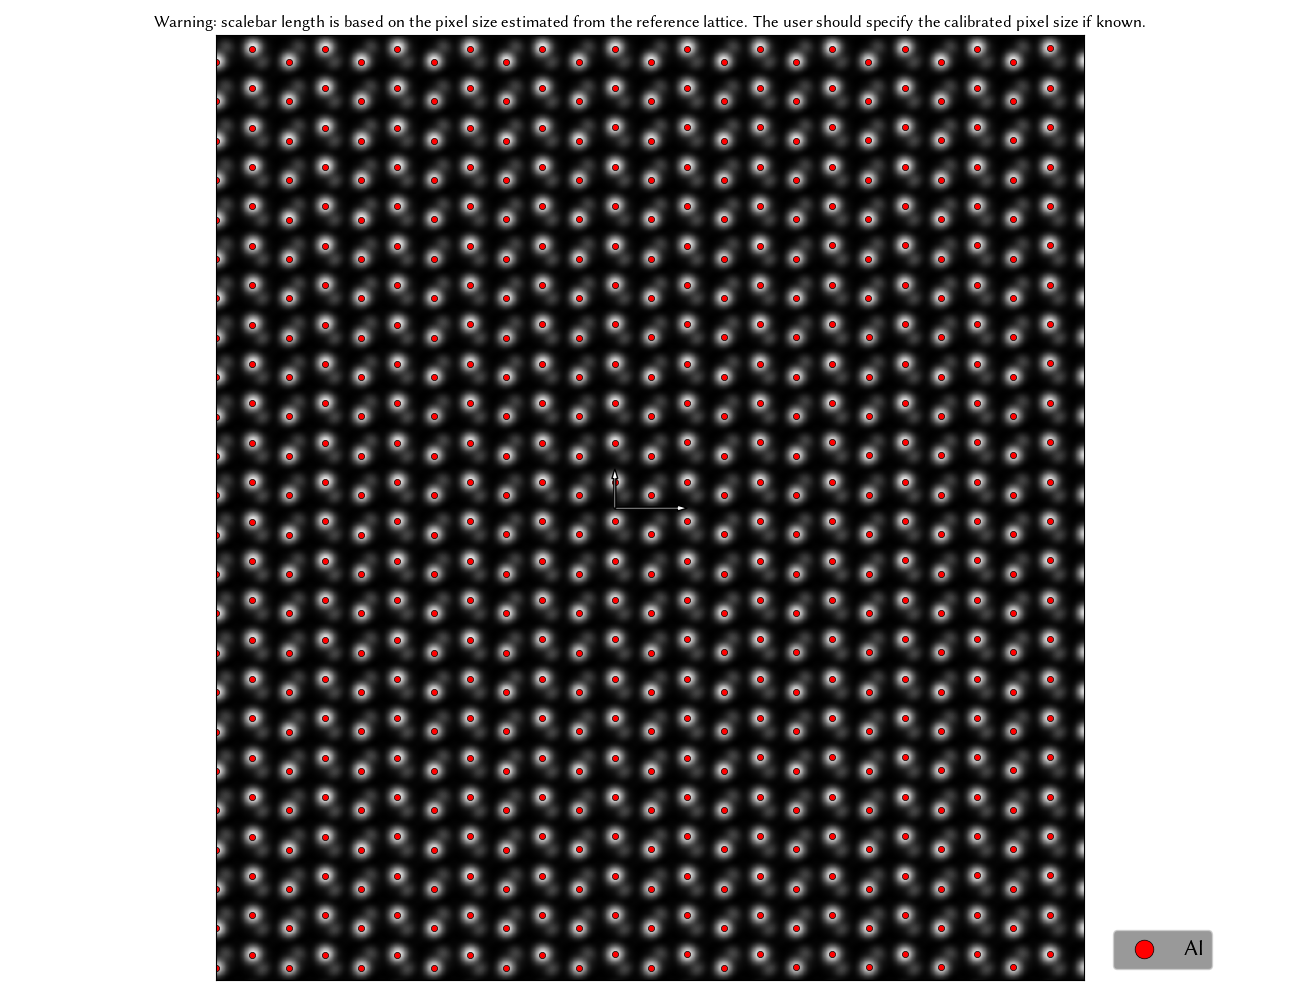

In [28]:
thk_hrimgs[0].plot_atom_column_positions(scatter_kwargs_dict={"s": 20}, scalebar_len_nm=None,
                                     outlier_disp_cutoff=100, fit_or_ref="ref")

Now that we have fitted atom columns, we need to marshall the data into a workable form for analysis.  After much thinking and trial/error, this is what I've come up with:

1. Pick any four contiguous coluns in a square: as long as we pick in a square like this, they will all be unique, and we don't need to register the exge of a projected cell in the (10x10 tiled) image to the model
2. Extract their intensities with a little bit of Pandas magic (read: this part was much harder to figure out than the length of the final code imples)
3. Arrange that data into a form that we can use to make some box plots, similar to what we did for the thin models

In [29]:
uvs = [(0, -1/3), (0, 2/3), (1/2, -2/3), (1/2, 1/3)]  # Should be 4 unique columns near the center of the image (no edge effects)

col_ints = []
for lat in thk_lattices:
    df = lat.at_cols
    inner_list = []
    for u, v in uvs:
        mask = np.isclose(df["u"], u, atol=1e-5) & np.isclose(df["v"], v, atol=1e-5)
        inner_list.append(df.loc[mask]["total_col_int"].iloc[0])
    col_ints.append(inner_list)

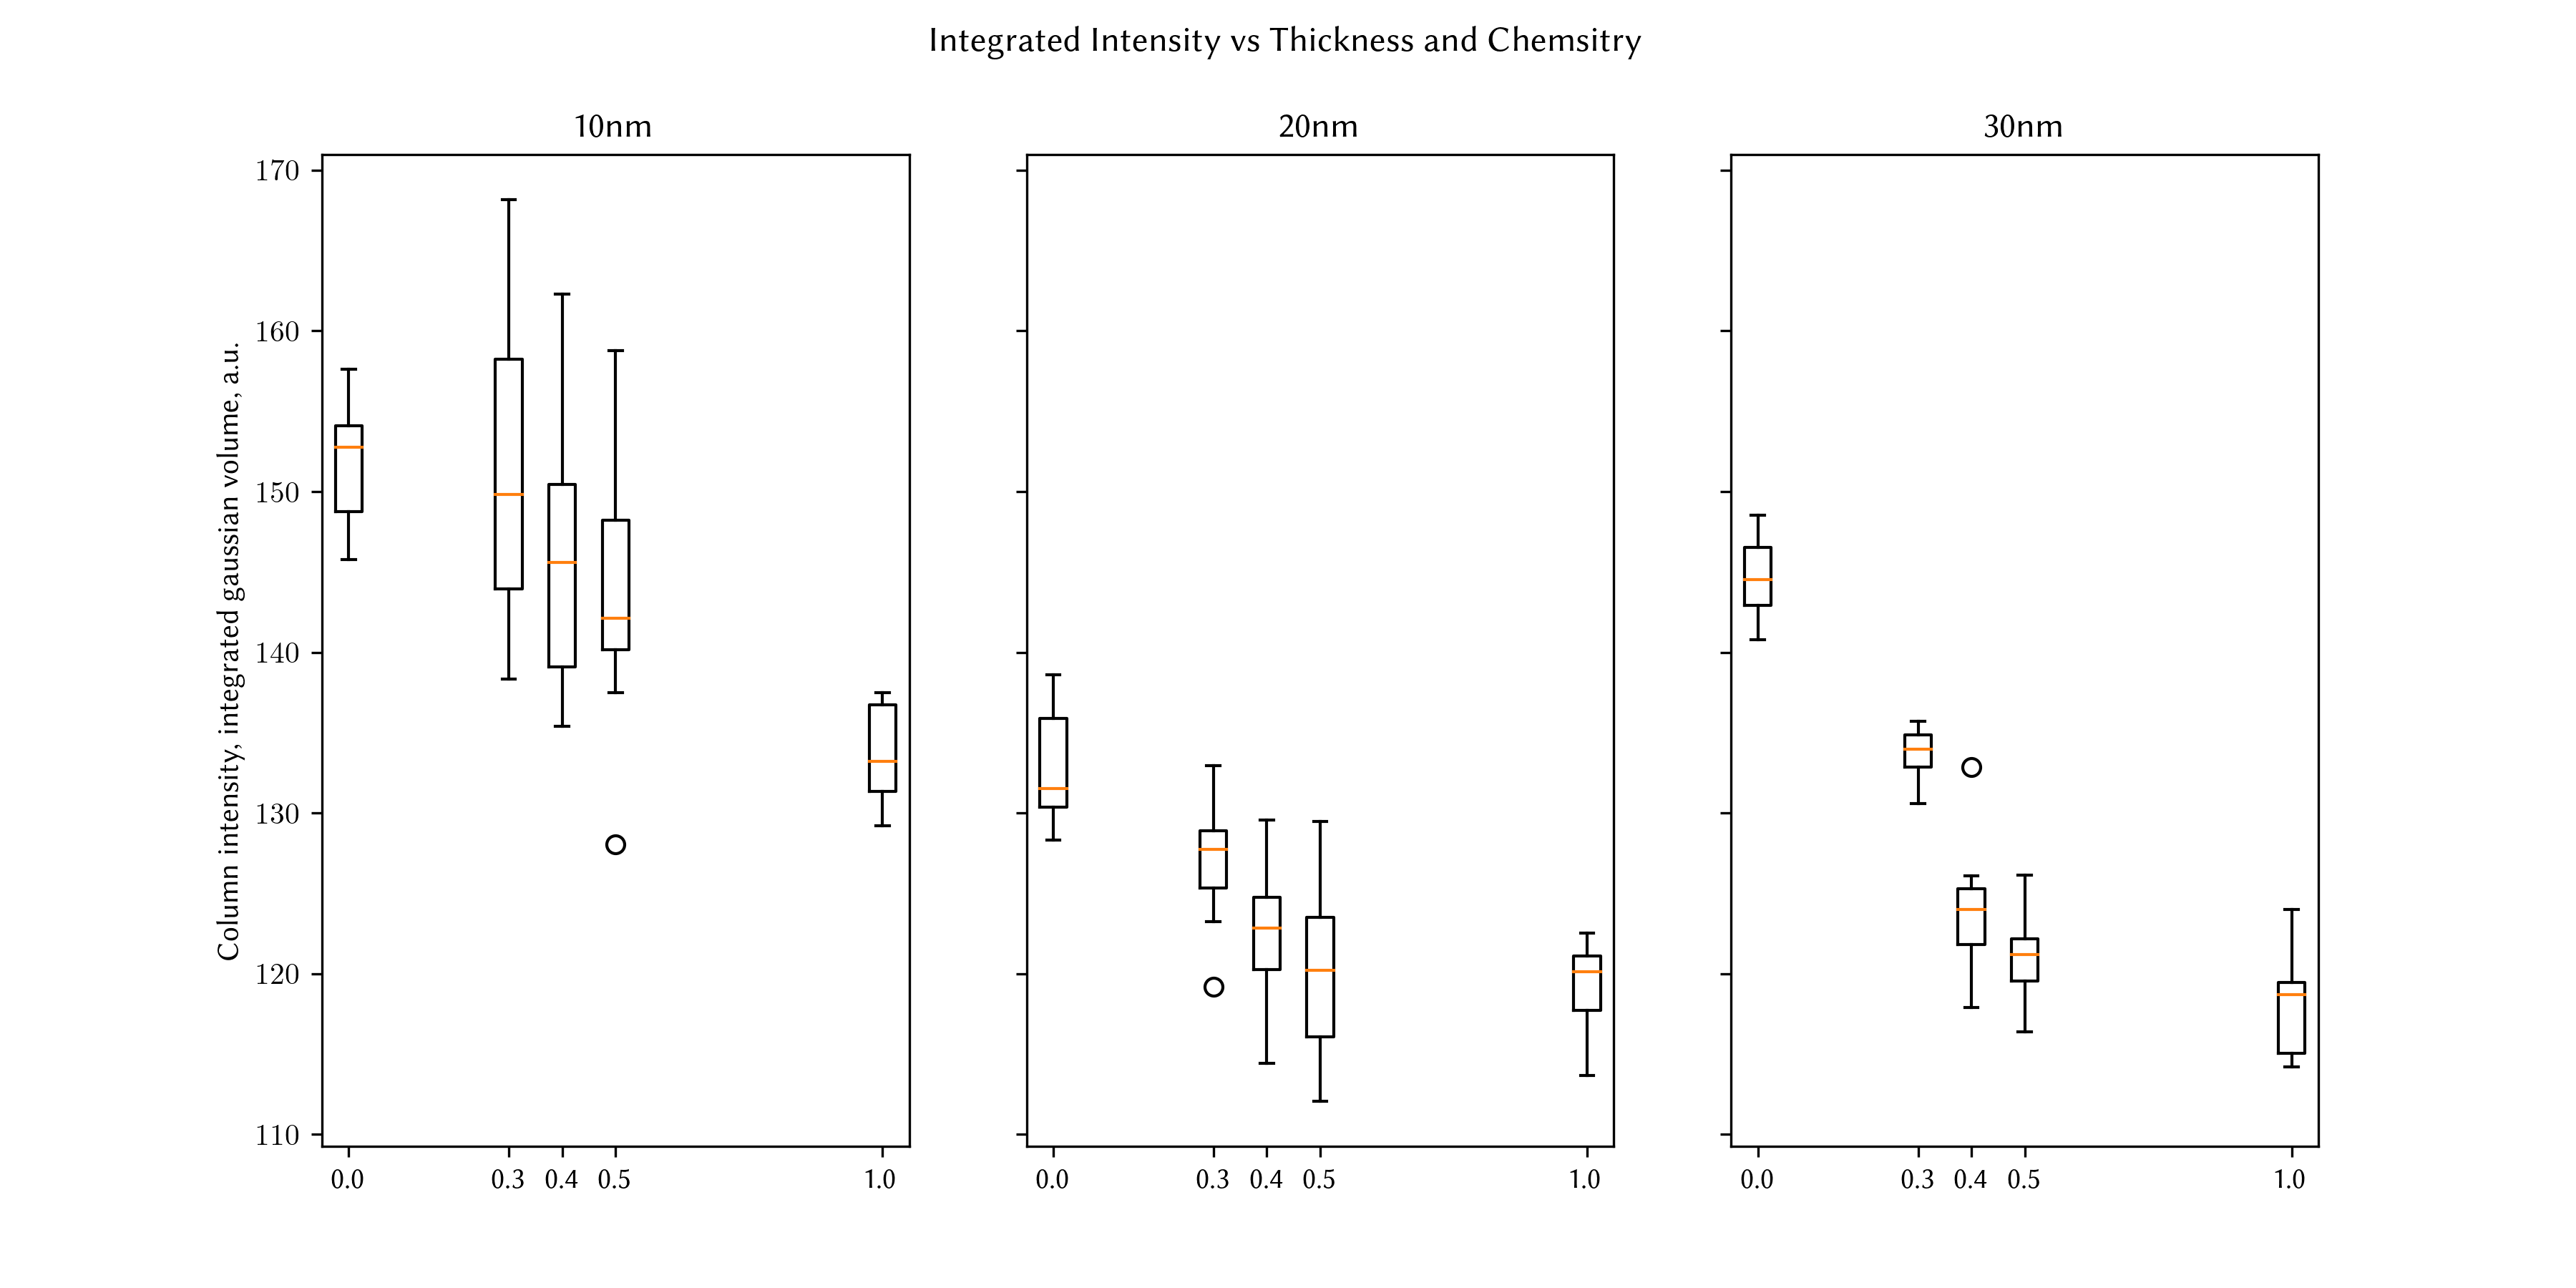

In [30]:
# We want to reshape col_ints to be amenable to box-plotting
# I'll use 3 separate lists for this, rather than making a big 3D list
# WARNING: If we change the structure of the conditions array, this will also need to be changed to match!

ints_10nm = [[it for sbl in col_ints[27:30] for it in sbl],  # c = 0.0
              [it for sbl in col_ints[0:3] for it in sbl],    # c = 0.3
              [it for sbl in col_ints[3:6] for it in sbl],    # c = 0.4
              [it for sbl in col_ints[6:9] for it in sbl],    # c = 0.5
              [it for sbl in col_ints[36:39] for it in sbl]]  # c = 1.0

ints_20nm = [[it for sbl in col_ints[30:33] for it in sbl],  # c = 0.0
              [it for sbl in col_ints[9:12] for it in sbl],   # c = 0.3
              [it for sbl in col_ints[12:15] for it in sbl],  # c = 0.4
              [it for sbl in col_ints[15:18] for it in sbl],  # c = 0.5
              [it for sbl in col_ints[39:42] for it in sbl]]  # c = 1.0

ints_30nm = [[it for sbl in col_ints[33:36] for it in sbl],  # c = 0.0
              [it for sbl in col_ints[18:21] for it in sbl],  # c = 0.3
              [it for sbl in col_ints[21:24] for it in sbl],  # c = 0.4
              [it for sbl in col_ints[24:27] for it in sbl],  # c = 0.5
              [it for sbl in col_ints[42:45] for it in sbl]]  # c = 1.0

%matplotlib widget
labs = ["0.0", "0.3", "0.4", "0.5", "1.0"]
fig, axs = plt.subplots(1, 3, sharey="all", dpi=300, figsize=[12, 6])

axs[0].set_title("10nm")
axs[0].boxplot(np.array(ints_10nm).T, positions=[0, 3, 4, 5, 10])
axs[0].set_xticklabels(labs)
axs[0].set_ylabel("Column intensity, integrated gaussian volume, a.u.")

axs[1].set_title("20nm")
axs[1].boxplot(np.array(ints_20nm).T, positions=[0, 3, 4, 5, 10])
axs[1].set_xticklabels(labs)

axs[2].set_title("30nm")
axs[2].boxplot(np.array(ints_30nm).T, positions=[0, 3, 4, 5, 10])
axs[2].set_xticklabels(labs)

plt.suptitle("Integrated Intensity vs Thickness and Chemsitry")
plt.savefig(Path("./_output/AlScN_thick/trends.png"))
plt.show()

In [31]:
# WARNING: I'm overwriting the variable name "clist" used in thin model boxplot generation, be careful!
clist = [0.0]*12 + [0.3]*12 + [0.4]*12 + [0.5]*12 + [1.0]*12

ilist_10nm = [it for sbl in ints_10nm for it in sbl]
ilist_20nm = [it for sbl in ints_20nm for it in sbl]
ilist_30nm = [it for sbl in ints_30nm for it in sbl]

fitted_10nm = np.polyfit(clist, ilist_10nm, deg=1, full=True)
fitted_20nm = np.polyfit(clist, ilist_20nm, deg=1, full=True)
fitted_30nm = np.polyfit(clist, ilist_30nm, deg=1, full=True)

print(f"10nm, R^2 = {round(1 - fitted_10nm[1][0] / np.sum((ilist_10nm - np.mean(ilist_10nm))**2), 3)}")
print(f"20nm, R^2 = {round(1 - fitted_20nm[1][0] / np.sum((ilist_20nm - np.mean(ilist_20nm))**2), 3)}")
print(f"30nm, R^2 = {round(1 - fitted_30nm[1][0] / np.sum((ilist_30nm - np.mean(ilist_30nm))**2), 3)}")

10nm, R^2 = 0.459
20nm, R^2 = 0.47
30nm, R^2 = 0.713
